### Dataset Creation

This is the notebook to train the classification of Diabetic Retinography with CNNs

This notebook contains the following
1. Dataset Creation and Augmentation
2. Train and Eval Functions
3. CNN Class Models (InceptionV3, ResNet50, ResNet152, EfficientNet, DenseNet, VGG16, MaxViT)

This notebook assumes the following project structure:
```bash
Root
├── notebooks
│   └── notebook1.ipynb
└── input
    └── Data
        ├── DDR
        │   ├── Train
        │   └── Test
        ── BEN
        │   ├── Train
        │   └── Test
        ├── CLAHE
        │   ├── Train
        │   └── Test
        ├── UNET_Binary
        │   ├── Train
        │   └── Test
        └── UNET_Multiclass
            ├── Train
            └── Test
```

If you do not have the dataset, please download it from our Google Drive

In [15]:
#Necessary Imports
import torch
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from tqdm import tqdm
import gc

### Dataset Creation

In [16]:
# Parameter required
image_size = (299,299)
batch_size = 64

# Defining Train Transforms
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontally with a 50% probability
    transforms.RandomVerticalFlip(p=0.5),  # Flip vertically with a 50% probability
    transforms.RandomAffine(
        degrees=360,  # Rotation
        translate=(0.1, 0.1),  # Translation
        scale=(0.8, 1.2) #Zooming
    ),
    transforms.ToTensor()
])


# Defining Evaluation Transforms, no data augmentation
eval_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

#### Ben Graham dataset

In [17]:
# Create PyTorch datasets for training and validation
ben_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/BEN/train', 
                    transform=train_transform
                    )
ben_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/BEN/val', 
                    transform=eval_transform
                    )
ben_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/BEN/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
ben_train_dataloader = torch.utils.data.DataLoader(
                    ben_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
ben_val_dataloader = torch.utils.data.DataLoader(
                    ben_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
ben_test_dataloader = torch.utils.data.DataLoader(
                    ben_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### CLAHE dataset

In [18]:
# Create PyTorch datasets for training and validation
clahe_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/CLAHE/train', 
                    transform=train_transform
                    )
clahe_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/CLAHE/val', 
                    transform=eval_transform
                    )
clahe_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/CLAHE/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
clahe_train_dataloader = torch.utils.data.DataLoader(
                    clahe_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
clahe_val_dataloader = torch.utils.data.DataLoader(
                    clahe_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
clahe_test_dataloader = torch.utils.data.DataLoader(
                    clahe_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### UNET_Binary Dataset

In [19]:
# Create PyTorch datasets for training and validation
unetb_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Binary/train', 
                    transform=train_transform
                    )
unetb_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Binary/val', 
                    transform=eval_transform
                    )
unetb_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Binary/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
unetb_train_dataloader = torch.utils.data.DataLoader(
                    unetb_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetb_val_dataloader = torch.utils.data.DataLoader(
                    unetb_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetb_test_dataloader = torch.utils.data.DataLoader(
                    unetb_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### UNET_Multiclass Dataset

In [20]:
# Create PyTorch datasets for training and validation
unetm_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Multiclass/train', 
                    transform=train_transform
                    )
unetm_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Multiclass/val', 
                    transform=eval_transform
                    )
unetm_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Multiclass/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
unetm_train_dataloader = torch.utils.data.DataLoader(
                    unetm_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetm_val_dataloader = torch.utils.data.DataLoader(
                    unetm_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetm_test_dataloader = torch.utils.data.DataLoader(
                    unetm_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### Visualisation

In [21]:
def visualise_img(dataloader, class_list: list):
    """
    Function to visualize the first 9 images of the dataset.

    Args:
        dataloader (DataLoader): PyTorch DataLoader object containing the dataset to visualize.
        class_list (list): List of class labels.
    """
    #Get the first batch of images and labels
    train_images, train_labels = next(iter(dataloader))
    batch_size = train_images.size(0)  # Get the batch size

    #Print the shape of the batch
    print(f"Images batch shape: {train_images.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

    #Create a 3x3 grid for visualization
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    for i in range(3):
        for j in range(3):
            #Get the index of the image in the batch
            index = i * 3 + j

            if index < batch_size:
                #Prepare image to print
                img = train_images[index].squeeze().numpy().transpose((1, 2, 0))
                label = train_labels[index].item()

                #Plot the image
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                axes[i, j].set_title(f'Label: {label}, {class_list[label]}', loc='left')

    plt.tight_layout()
    plt.show()

Images batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


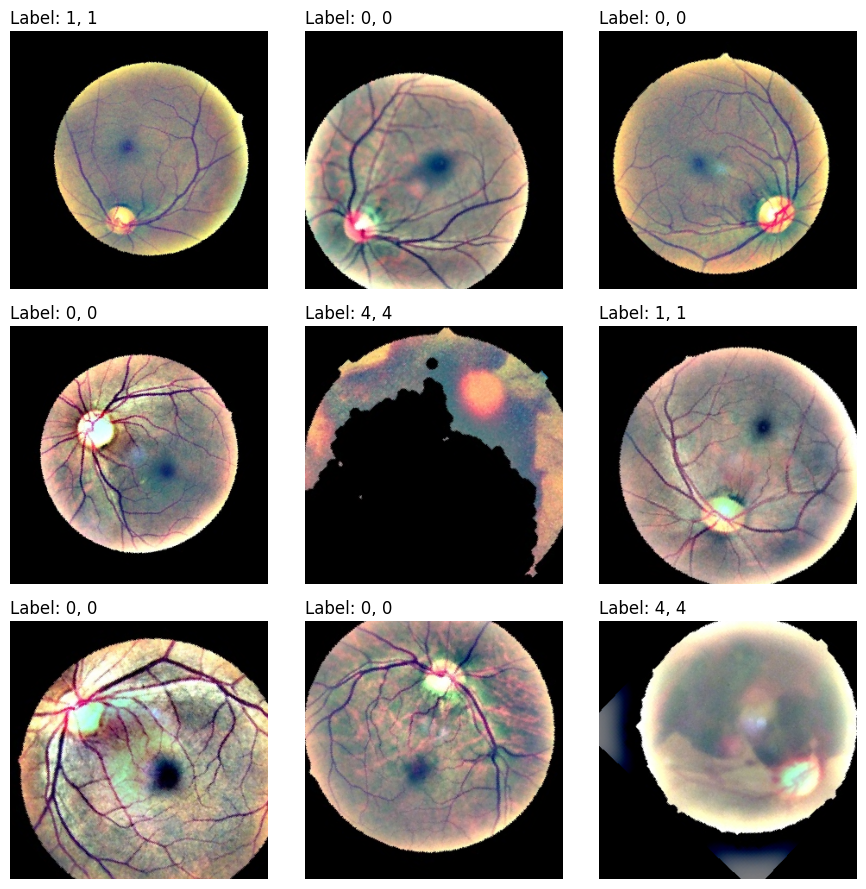

In [22]:
visualise_img(ben_train_dataloader, ben_train_dataset.classes)

Images batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


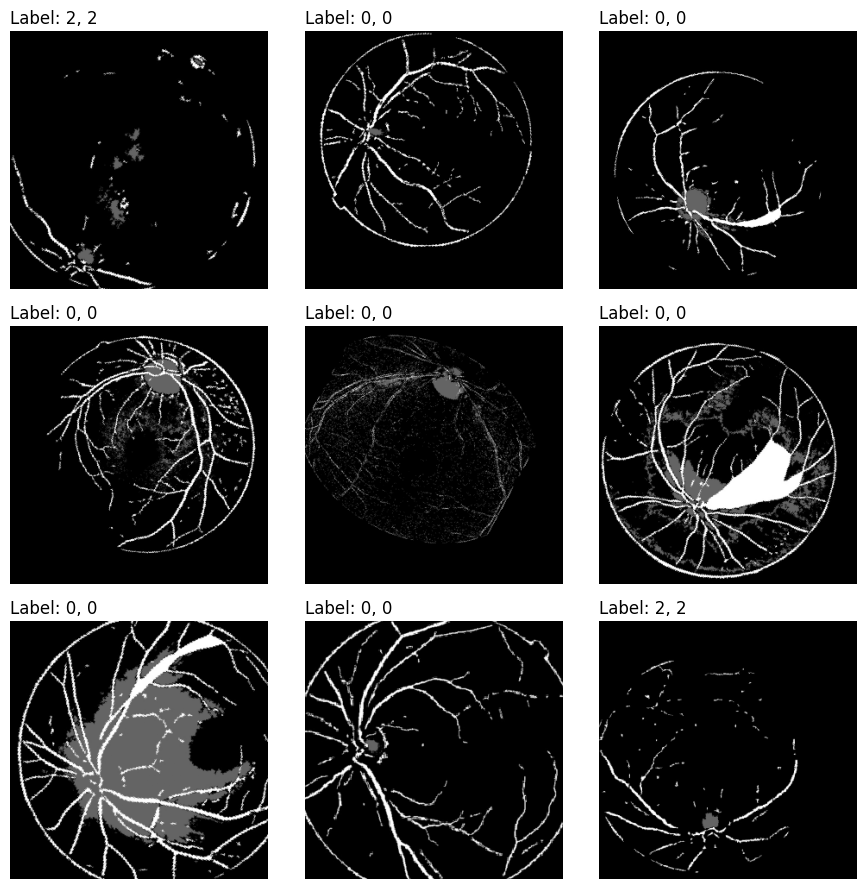

In [23]:
visualise_img(clahe_train_dataloader, clahe_train_dataset.classes)

Images batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


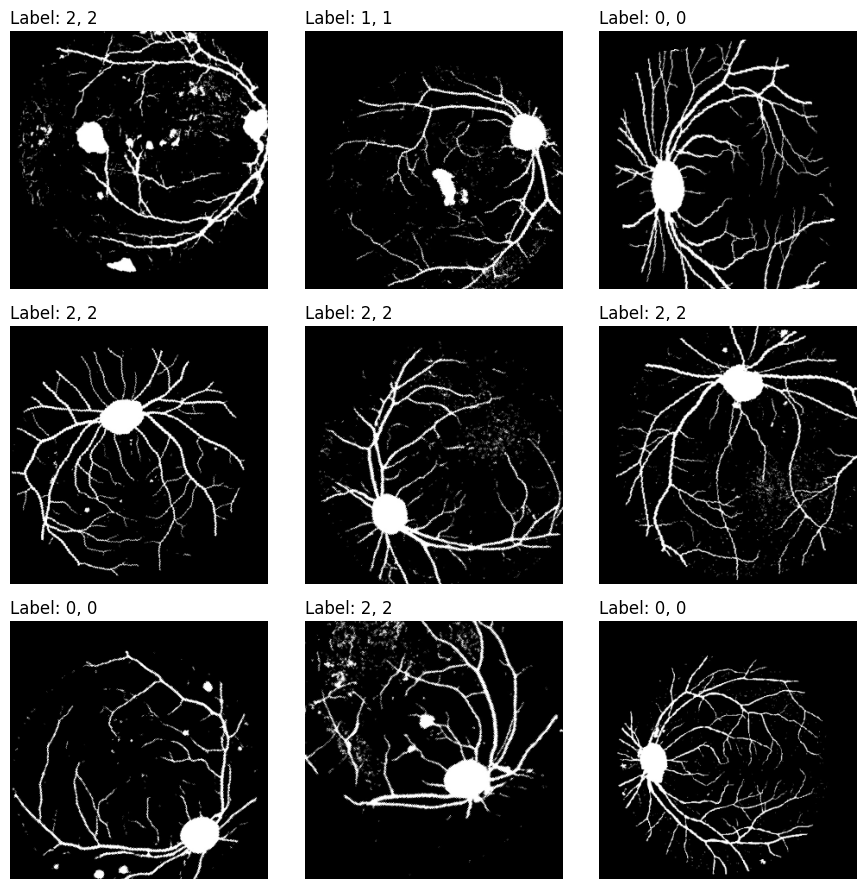

In [24]:
visualise_img(unetb_train_dataloader, unetb_train_dataset.classes)

Images batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64])


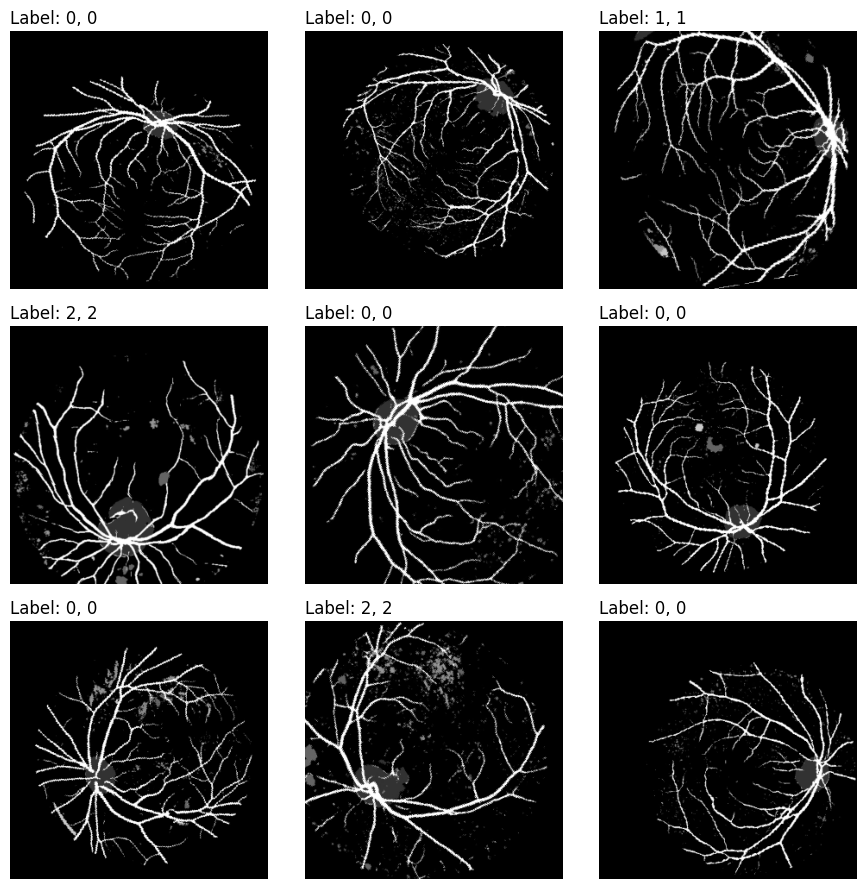

In [25]:
visualise_img(unetm_train_dataloader, unetm_train_dataset.classes)

### Train, Eval Functions

In [26]:
import torch

def eval(model, 
         criterion, 
         img_size:tuple,
         val_dataloader, 
         device='cuda'):
    """
    Evaluation function for finetuning CNN models with a model object,
    incorporating average sensitivity for a multiclass problem.

    Sensitivity function: True Positives / (True Positives + False Negatives)

    Args:
        model: model to be trained
        criterion: loss function
        img_size (tuple): image size of dataset for model. All inputs will be resized to image size
        val_dataloader: val / test dataloader
        device (str, optional): 'cpu' or 'cuda', defaults to cuda.

    Returns:
        val_loss: float of the average val loss.
        val_accuracy: float of the accuracy.
        val_sensitivity: float of the average sensitivity across all classes.
    """

    model = model.to(device)
    
    #set model to eval mode
    model.eval()

    #variables 
    val_loss = 0.0
    correct = 0
    total = 0
    n_classes = 5
    true_positives = [0] * n_classes #stores num of true positives per class
    actual_positives = [0] * n_classes #stores total number of positives per class
    total_sensitivity = 0

    with torch.no_grad():
        for image, label in val_dataloader:
            batch_sensitivity = 0

            #resize image with bilinear, same as torchvision.transforms.Resize()
            image = torch.nn.functional.interpolate(image, size=img_size, mode='bilinear') 
            image, label = image.to(device), label.to(device)

            outputs = model(image)  #predict label
            loss = criterion(outputs, label)  #calculate loss
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1) #get prediction
            total += label.size(0)
            correct += (predicted == label).sum().item()

            for i in range(n_classes):
                true_positives[i] += ((predicted == i) & (label == i)).sum().item() #true positives
                actual_positives[i] += (label == i).sum().item() #true positives + false negatives
            
                if (label == i).sum().item() > 0:
                    batch_sensitivity += true_positives[i] / actual_positives[i]

                else:
                    pass
            
            total_sensitivity += batch_sensitivity/n_classes #average sensitivity for batch

    # Calculate accuracy, avg loss, and avg sensitivity
    accuracy = (correct / total) * 100
    avg_val_loss = val_loss / len(val_dataloader)
    avg_sensitivity = total_sensitivity/len(val_dataloader)
    
    return avg_val_loss, accuracy, avg_sensitivity


In [27]:
def train(model, 
          criterion, 
          optimiser, 
          img_size:tuple,
          train_dataloader, 
          val_dataloader=None, 
          saving_metric:str='sensitivity',
          num_epochs:int=25, 
          device:str='cuda', 
          model_name:str=None):
    """
    Training Function to train model
    Runs validation for each epoch to calculate: Validation Loss, Validation Accuracy, Validation Sensitivity
    Best and last model will be saved to ../models/cnn under {model_name}_best.pt and {model_name}_last.pt
    
    Args:
        model: model to be trained
        criterion: loss function
        optimiser: optimiser chosen
        img_size (tuple): image size of dataset for model. All inputs will be resized to image size
        train_dataloader: train dataloader
        val_dataloader (optional): val dataloader, if None no validation will be calculated. Defaults to None.
        saving_metric (str, optional): saving metrics for best model, either "loss", "accuracy", or "sensitivity". Defaults to 'sensitivity'.
        num_epochs (int, optional): number of training epochs. Defaults to 25.
        device (str, optional): cuda or cpu. Defaults to 'cuda'.
        model_name (str, optional): model name to be saved, if None no model will be saved. Defaults to None.

    Returns:
        results_dataframe: dataframe of [model, train_loss, val_loss, val_accuracy, val_sensitivity] where each row is each epoch
    """

    if saving_metric not in ["loss", "accuracy", "sensitivity"]:
        raise Exception("Invalid saving metrics found, please only use loss, accuracy or sensitivity")

    #initialising results container
    results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])
    
    #placeholders
    val_loss = ''
    val_accuracy = ''
    val_sensitivity = ''


    for epoch in range(num_epochs):

        #initialising training
        model.train()
        training_loss = 0.0

        for image, label in tqdm(train_dataloader):
            
            #resize image with bilinear, same as torchvision.transforms.Resize()
            image = torch.nn.functional.interpolate(image, size=img_size, mode='bilinear') 
            image, label = image.to(device), label.to(device)

            optimiser.zero_grad()
            outputs = model(image)
            #calculate loss and train model
            loss = criterion(outputs, label)
            loss.backward()
            optimiser.step()
            training_loss += loss.item() #update the training loss

        epoch_loss = training_loss / len(train_dataloader) #calculate training loss in epoch
        print(f"Epoch {epoch+1} completed, training loss: {epoch_loss}")

        #validation
        if val_dataloader is not None:
            model.eval()  #set model to evaluate mode
            val_loss, val_accuracy,  val_sensitivity = eval(model=model, 
                                                               criterion=criterion,
                                                                val_dataloader=val_dataloader, 
                                                                img_size = img_size,
                                                                device=device) 
            
            print(f"Validation loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}, Validation Sensitivty: {val_sensitivity:2f}")
            

            if saving_metric == 'loss' and len(results) > 0 and val_loss < min(results['val loss'].to_list()):
                torch.save(model, f'../models/cnn/{model_name}_best.pt')
                print("Best model saved")

            elif saving_metric == 'accuracy' and len(results) > 0 and val_accuracy > max(results['val accuracy'].to_list()):
                torch.save(model, f'../models/cnn/{model_name}_best.pt')
                print("Best model saved")

            elif saving_metric == 'sensitivity' and len(results) > 0 and val_sensitivity > max(results['val sensitivity'].to_list()):
                torch.save(model, f'../models/cnn/{model_name}_best.pt')
                print("Best model saved")
            
        #updating results
        results.loc[len(results)] = [model_name, epoch_loss, val_loss, val_accuracy, val_sensitivity]


    #save the last model
    if model_name is not None:
        torch.save(model, f'../models/cnn/{model_name}_last.pt')

    return results


### Model

In [28]:
class PreTrainedCNNModels(torch.nn.Module):
    def __init__(self, model_type:str, num_unfreeze:int, num_class:int):
        super(PreTrainedCNNModels, self).__init__()
        """
        Class that contains InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit fine tuned models

        Args:
            model_type (str): Determines which pre-trained models to use
                              Must be: InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit
            num_unfreeze (int): Number of layers to unfreeze and finetune
            num_class (int): Number of output classes for the classification
        """
        #selecting model type
        if model_type == 'InceptionV3':
            self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
            self.model.aux_logits = False

        elif model_type == 'Resnet50':
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        elif model_type == 'Resnet152':
            self.model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

        elif model_type == 'EfficientNet':
            self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

        elif model_type == 'DenseNet':
            self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        
        elif model_type == 'VGG16':
            self.model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)

        elif model_type == 'MaxVit':
            self.model = models.maxvit_t(weights=models.MaxVit_T_Weights.DEFAULT)
        
        else:
            raise Exception("Invalid model type chosen. Please select one of the following\n[InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit]")

        
        #modifying final layer
        if model_type in ['InceptionV3', 'Resnet50', 'Resnet152']:
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_class)

        elif model_type == 'DenseNet':
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_class)

        else:
            self.model.classifier[-1] = torch.nn.Linear(self.model.classifier[-1].in_features, num_class)


        model_paramteres = list(self.model.parameters())
        #unfreeze last num_unfreeze layers
        for param in model_paramteres[-num_unfreeze:]:
            param.requires_grad = True

        #freeze rest of the layers
        for param in model_paramteres[:-num_unfreeze]:
            param.requires_grad = False


    def forward(self, images):
        return self.model(images)

### SVM (ben data)

In [29]:
def calculate_class_weights(image_folder_dataloader):
    # Counting the number of samples in each class
    class_counts = np.bincount(image_folder_dataloader.dataset.targets)
    total_samples = sum(class_counts)
    num_classes = len(class_counts)
    
    # Calculating class weights inversely proportional to the number of samples in each class
    weights = total_samples / (num_classes * class_counts)
    
    # Normalizing the weights so that the weight for class 0 is 1
    normalized_weights = weights / weights[0]
    
    return weights

In [30]:
class_weights = calculate_class_weights(ben_train_dataloader)
print(class_weights)

[ 0.40443009  3.8864745   0.55102169 10.37159763  2.78664547]


In [37]:
densenet_0_16 = torch.load(r'H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_0_16_last.pt')
densenet_1_2= torch.load(r'H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_2_best.pt')
densenet_1_8= torch.load(r'H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_8_best.pt')
densenet_1_16= torch.load(r'H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_16_last.pt')
densenet_0_2 = torch.load(r'H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_weighted_last.pt')
densenet_0_8 =torch.load(r'H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_8_weighted_last.pt')
densenet_0_32 = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_0_32_Ben_best.pt")
densenet_1_32 = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_32_Ben_best.pt")

maxvit_0_16= torch.load(r'H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_16_last.pt')
maxvit_1_2= torch.load(r'H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_2_last.pt')
maxvit_1_8= torch.load(r'H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_8_best.pt')
maxvit_1_16= torch.load(r'H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_16_last.pt')
maxvit_0_2 = torch.load(r'H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_2_last.pt')
maxvit_0_8 =torch.load(r'H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_8_best.pt')
maxvit_0_32 = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_32_last.pt")
maxvit_1_32 = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_32_last.pt")


In [38]:
densenet_0_16_outputs = []
densenet_1_2_outputs= []
densenet_1_8_outputs= []
densenet_1_16_outputs= []
densenet_0_2_outputs= []
densenet_0_8_outputs= []
densenet_0_32_outputs= []
densenet_1_32_outputs= []

maxvit_0_16_outputs= []
maxvit_1_2_outputs= []
maxvit_1_8_outputs= []
maxvit_1_16_outputs= []
maxvit_0_2_outputs= []
maxvit_0_8_outputs= []
maxvit_0_32_outputs= []
maxvit_1_32_outputs= []

true_labels = []

densenet_0_16.eval()
densenet_1_2.eval()
densenet_1_8.eval()
densenet_1_16.eval()
densenet_0_2.eval()
densenet_0_8.eval()
densenet_0_32.eval()
densenet_1_32.eval()

maxvit_0_16.eval()
maxvit_1_2.eval()
maxvit_1_8.eval()
maxvit_1_16.eval()
maxvit_0_2.eval()
maxvit_0_8.eval()
maxvit_0_32.eval()
maxvit_1_32.eval()


with torch.no_grad():
    for images, label in tqdm(ben_train_dataloader):

        images = torch.nn.functional.interpolate(images, size=(224,224), mode='bilinear').to('cuda')
        # Pass images through model1
        output1 = densenet_0_16(images)
        densenet_0_16_outputs.append(output1)


        # Pass images through model2
        output1 = densenet_1_2(images)
        densenet_1_2_outputs.append(output1)

        output2 = densenet_1_8(images)
        densenet_1_8_outputs.append(output2)

        output2 = densenet_1_16(images)
        densenet_1_16_outputs.append(output2)

        output2 = densenet_0_2(images)
        densenet_0_2_outputs.append(output2)

        output2 = densenet_0_8(images)
        densenet_0_8_outputs.append(output2)

        output2 = densenet_0_32(images)
        densenet_0_32_outputs.append(output2)

        output2 = densenet_1_32(images)
        densenet_1_32_outputs.append(output2)

        output2 = maxvit_0_16(images)
        maxvit_0_16_outputs.append(output2)

        output2 = maxvit_1_2(images)
        maxvit_1_2_outputs.append(output2)

        output2 = maxvit_1_8(images)
        maxvit_1_8_outputs.append(output2)

        output2 = maxvit_1_16(images)
        maxvit_1_16_outputs.append(output2)

        output2 = maxvit_0_2(images)
        maxvit_0_2_outputs.append(output2)

        output2 = maxvit_0_8(images)
        maxvit_0_8_outputs.append(output2)

        output2 = maxvit_0_32(images)
        maxvit_0_32_outputs.append(output2)

        output2 = maxvit_1_32(images)
        maxvit_1_32_outputs.append(output2)

        true_labels.extend(label)

100%|██████████| 137/137 [02:23<00:00,  1.05s/it]


In [39]:
densenet_0_16_test_outputs=[]
densenet_1_2_test_outputs=[]
densenet_1_8_test_outputs=[]
densenet_1_16_test_outputs=[]
densenet_0_2_test_outputs= []
densenet_0_8_test_outputs= []
densenet_0_32_test_outputs= []
densenet_1_32_test_outputs= []

maxvit_0_16_test_outputs=[]
maxvit_1_2_test_outputs=[]
maxvit_1_8_test_outputs=[]
maxvit_1_16_test_outputs=[]
maxvit_0_2_test_outputs= []
maxvit_0_8_test_outputs= []
maxvit_0_32_test_outputs= []
maxvit_1_32_test_outputs= []

true_test_labels = []

densenet_0_16.eval()
densenet_1_2.eval()
densenet_1_8.eval()
densenet_1_16.eval()
densenet_0_2.eval()
densenet_0_8.eval()
densenet_0_32.eval()
densenet_1_32.eval()

maxvit_0_16.eval()
maxvit_1_2.eval()
maxvit_1_8.eval()
maxvit_1_16.eval()
maxvit_0_2.eval()
maxvit_0_8.eval()
maxvit_0_32.eval()
maxvit_1_32.eval()




with torch.no_grad():
    for images, label in tqdm(ben_test_dataloader):

        images = torch.nn.functional.interpolate(images, size=(224,224), mode='bilinear').to('cuda')
        # Pass images through model1
        output1 = densenet_0_16(images)
        densenet_0_16_test_outputs.append(output1)

        # Pass images through model2
        output1 = densenet_1_2(images)
        densenet_1_2_test_outputs.append(output1)

        output2 = densenet_1_8(images)
        densenet_1_8_test_outputs.append(output2)

        output2 = densenet_1_16(images)
        densenet_1_16_test_outputs.append(output2)

        output = densenet_0_2(images)
        densenet_0_2_test_outputs.append(output2)

        output2 = densenet_0_8(images)
        densenet_0_8_test_outputs.append(output2)

        output2 = densenet_0_32(images)
        densenet_0_32_test_outputs.append(output2)

        output2 = densenet_1_32(images)
        densenet_1_32_test_outputs.append(output2)

        output2 = maxvit_0_16(images)
        maxvit_0_16_test_outputs.append(output2)

        output2 = maxvit_1_2(images)
        maxvit_1_2_test_outputs.append(output2)

        output2 = maxvit_1_8(images)
        maxvit_1_8_test_outputs.append(output2)

        output2 = maxvit_1_16(images)
        maxvit_1_16_test_outputs.append(output2)

        output2 = maxvit_0_2(images)
        maxvit_0_2_test_outputs.append(output2)

        output2 = maxvit_0_8(images)
        maxvit_0_8_test_outputs.append(output2)

        output2 = maxvit_0_32(images)
        maxvit_0_32_test_outputs.append(output2)

        output2 = maxvit_1_32(images)
        maxvit_1_32_test_outputs.append(output2)

        true_test_labels.extend(label)


densenet_0_16_test_outputs = torch.cat(densenet_0_16_test_outputs, dim=0)
densenet_1_2_test_outputs= torch.cat(densenet_1_2_test_outputs, dim=0)
densenet_1_8_test_outputs= torch.cat(densenet_1_8_test_outputs, dim=0)
densenet_1_16_test_outputs= torch.cat(densenet_1_16_test_outputs, dim=0)
densenet_0_2_test_outputs= torch.cat(densenet_0_2_test_outputs, dim=0)
densenet_0_8_test_outputs= torch.cat(densenet_0_8_test_outputs, dim=0)
densenet_0_32_test_outputs= torch.cat(densenet_0_32_test_outputs, dim=0)
densenet_1_32_test_outputs= torch.cat(densenet_1_32_test_outputs, dim=0)


maxvit_0_16_test_outputs= torch.cat(maxvit_0_16_test_outputs, dim=0)
maxvit_1_2_test_outputs= torch.cat(maxvit_1_2_test_outputs, dim=0)
maxvit_1_8_test_outputs= torch.cat(maxvit_1_8_test_outputs, dim=0)
maxvit_1_16_test_outputs= torch.cat(maxvit_1_16_test_outputs, dim=0)
maxvit_0_2_test_outputs= torch.cat(maxvit_0_2_test_outputs, dim=0)
maxvit_0_8_test_outputs= torch.cat(maxvit_0_8_test_outputs, dim=0)
maxvit_0_32_test_outputs= torch.cat(maxvit_0_32_test_outputs, dim=0)
maxvit_1_32_test_outputs= torch.cat(maxvit_1_32_test_outputs, dim=0)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


In [40]:
import torch
from sklearn.svm import SVC
from sklearn.metrics import recall_score

densenet_0_16_outputs= torch.cat(densenet_0_16_outputs, dim=0)
densenet_1_2_outputs= torch.cat(densenet_1_2_outputs, dim=0)
densenet_1_8_outputs= torch.cat(densenet_1_8_outputs, dim=0)
densenet_1_16_outputs= torch.cat(densenet_1_16_outputs, dim=0)
densenet_0_2_outputs= torch.cat(densenet_0_2_outputs, dim=0)
densenet_0_8_outputs= torch.cat(densenet_0_8_outputs, dim=0)
densenet_0_32_outputs= torch.cat(densenet_0_32_outputs, dim=0)
densenet_1_32_outputs= torch.cat(densenet_1_32_outputs, dim=0)

maxvit_0_16_outputs= torch.cat(maxvit_0_16_outputs, dim=0)
maxvit_1_2_outputs= torch.cat(maxvit_1_2_outputs, dim=0)
maxvit_1_8_outputs= torch.cat(maxvit_1_8_outputs, dim=0)
maxvit_1_16_outputs= torch.cat(maxvit_1_16_outputs, dim=0)
maxvit_0_2_outputs= torch.cat(maxvit_0_2_outputs, dim=0)
maxvit_0_8_outputs= torch.cat(maxvit_0_8_outputs, dim=0)
maxvit_0_32_outputs= torch.cat(maxvit_0_32_outputs, dim=0)
maxvit_1_32_outputs= torch.cat(maxvit_1_32_outputs, dim=0)

In [98]:
concatenated_outputs = torch.cat((densenet_0_16_outputs, densenet_1_2_outputs), dim=1).cpu().detach().numpy()
all_labels = np.array(true_labels)
svm_classifier = SVC(decision_function_shape='ovo')

# Train SVM on the concatenated model outputs
svm_classifier.fit(concatenated_outputs, all_labels)

SVC(decision_function_shape='ovo')

In [99]:
# Predict on validation set

test_outputs = torch.cat((densenet_0_16_test_outputs, densenet_1_2_test_outputs), dim=1).cpu().detach().numpy()
predictions = svm_classifier.predict(test_outputs)

# Evaluate accuracy
recall = recall_score(true_test_labels, predictions, average='weighted')
print(recall)

0.7807344332091538


In [100]:
from sklearn.svm import LinearSVC

svm2_classifier = LinearSVC()
svm2_classifier.fit(concatenated_outputs, true_labels)

c:\Users\valkr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [101]:
# Predict on validation set
test_outputs = torch.cat((densenet_0_16_test_outputs, densenet_1_2_test_outputs), dim=1).cpu().detach().numpy()
predictions = svm2_classifier.predict(test_outputs)

# Evaluate accuracy
recall = recall_score(true_test_labels, predictions, average='weighted')
print(recall)

0.7796700372538584


In [102]:
models_to_try = ['densenet_0_16', 'maxvit_0_16']

model1, model2 = f"{models_to_try[0]}_outputs", f"{models_to_try[1]}_outputs"
test1, test2 = f"{models_to_try[0]}_test_outputs", f"{models_to_try[1]}_test_outputs"

concatenated_outputs = torch.cat((globals()[model1], globals()[model2]), dim=1).cpu().detach().numpy()
true_labels = np.array(true_labels)
svm_classifier = SVC(decision_function_shape='ovo')

# Train SVM on the concatenated model outputs
svm_classifier.fit(concatenated_outputs, true_labels)

# Predict on validation set

test_outputs = torch.cat((globals()[test1], globals()[test2]), dim=1).cpu().detach().numpy()
predictions = svm_classifier.predict(test_outputs)

# Evaluate accuracy
recall = recall_score(true_test_labels, predictions, average='weighted')
print(recall)

0.7828632251197446


In [109]:
import pandas as pd

# List to store the results
results = []
variables = ['densenet_0_16', 'densenet_1_2', 'densenet_1_8', 'densenet_1_16','densenet_0_2', 'densenet_0_8','densenet_0_32','densenet_1_32','maxvit_0_16', 'maxvit_1_2', 'maxvit_1_8','maxvit_1_16','maxvit_0_2','maxvit_0_8', 'maxvit_0_32','maxvit_1_32']

for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        if variables[i].split('_')[0] == variables[j].split('_')[0]:
            continue
        else:
            model1, model2 = f"{variables[i]}_outputs", f"{variables[j]}_outputs"
            test1, test2 = f"{variables[i]}_test_outputs", f"{variables[j]}_test_outputs"

            concatenated_outputs = torch.cat((globals()[model1], globals()[model2]), dim=1).cpu().detach().numpy()
            all_labels = np.array(true_labels)
            svm_classifier = SVC(decision_function_shape='ovo')

            # Train SVM on the concatenated model outputs
            svm_classifier.fit(concatenated_outputs, all_labels)

            # Predict on validation set
            test_outputs = torch.cat((globals()[test1], globals()[test2]), dim=1).cpu().detach().numpy()
            predictions = svm_classifier.predict(test_outputs)

            # Evaluate accuracy
            recall = recall_score(true_test_labels, predictions, average='weighted')

            # Save the result
            results.append({
                'Model 1': variables[i],
                'Model 2': variables[j],
                'Recall': recall
            })

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Save the DataFrame to a CSV file
df_results.to_csv('results/densenet_maxvit_ben_svm.csv', index=False)


### 8 layers

In [140]:
dense = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_weighted_last.pt")
efficient = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\EfficientNet_weighted_best.pt")
incept = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\InceptionV3_weighted_last.pt")
maxvit = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_weighted_best.pt")
resnet50 = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\Resnet50_weighted_best.pt")
resnet152 = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\Resnet152_weighted_last.pt")
vgg = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\VGG16_weighted_last.pt")

In [141]:
dense_outputs = []
efficient_outputs = []
incept_outputs = []
maxvit_outputs = []
resnet50_outputs =[]
resnet152_outputs = []
vgg_outputs = []

true_labels = []

dense.eval()
efficient.eval()
incept.eval()
maxvit.eval()
resnet50.eval()
resnet152.eval()
vgg.eval()


with torch.no_grad():
    for images, label in tqdm(ben_train_dataloader):

        images = torch.nn.functional.interpolate(images, size=(299,299), mode='bilinear').to('cuda')
        # Pass images through model1
        output1 = incept(images)
        incept_outputs.append(output1)

        images = torch.nn.functional.interpolate(images, size=(224,224), mode='bilinear')

        # Pass images through model2
        output1 = dense(images)
        dense_outputs.append(output1)

        output2 = efficient(images)
        efficient_outputs.append(output2)

        output2 = maxvit(images)
        maxvit_outputs.append(output2)

        output2 = resnet50(images)
        resnet50_outputs.append(output2)

        output2 = resnet152(images)
        resnet152_outputs.append(output2)

        output2 = vgg(images)
        vgg_outputs.append(output2)

        true_labels.extend(label)

100%|██████████| 137/137 [00:50<00:00,  2.73it/s]


In [142]:
dense_test_outputs = []
efficient_test_outputs = []
incept_test_outputs = []
maxvit_test_outputs = []
resnet50_test_outputs =[]
resnet152_test_outputs = []
vgg_test_outputs = []

true_test_labels = []

dense.eval()
efficient.eval()
incept.eval()
maxvit.eval()
resnet50.eval()
resnet152.eval()
vgg.eval()


with torch.no_grad():
    for images, label in tqdm(ben_test_dataloader):

        images = torch.nn.functional.interpolate(images, size=(299,299), mode='bilinear').to('cuda')
        # Pass images through model1
        output1 = incept(images)
        incept_test_outputs.append(output1)

        images = torch.nn.functional.interpolate(images, size=(224,224), mode='bilinear')

        # Pass images through model2
        output1 = dense(images)
        dense_test_outputs.append(output1)

        output2 = efficient(images)
        efficient_test_outputs.append(output2)

        output2 = maxvit(images)
        maxvit_test_outputs.append(output2)

        output2 = resnet50(images)
        resnet50_test_outputs.append(output2)

        output2 = resnet152(images)
        resnet152_test_outputs.append(output2)

        output2 = vgg(images)
        vgg_test_outputs.append(output2)

        true_test_labels.extend(label)


dense_test_outputs = torch.cat(dense_test_outputs, dim=0)
efficient_test_outputs = torch.cat(efficient_test_outputs, dim=0)
incept_test_outputs = torch.cat(incept_test_outputs, dim=0)
maxvit_test_outputs = torch.cat(maxvit_test_outputs, dim=0)
resnet50_test_outputs = torch.cat(resnet50_test_outputs, dim=0)
resnet152_test_outputs = torch.cat(resnet152_test_outputs, dim=0)
vgg_test_outputs = torch.cat(vgg_test_outputs, dim=0)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:10<00:00,  2.78it/s]


In [143]:
import torch
from sklearn.svm import SVC
from sklearn.metrics import recall_score

dense_outputs = torch.cat(dense_outputs, dim=0)
efficient_outputs = torch.cat(efficient_outputs, dim=0)
incept_outputs = torch.cat(incept_outputs, dim=0)
maxvit_outputs = torch.cat(maxvit_outputs, dim=0)
resnet50_outputs = torch.cat(resnet50_outputs, dim=0)
resnet152_outputs = torch.cat(resnet152_outputs, dim=0)
vgg_outputs = torch.cat(vgg_outputs, dim=0)

In [144]:
concatenated_outputs = torch.cat((dense_outputs, maxvit_outputs), dim=1).cpu().detach().numpy()
true_labels = np.array(true_labels)
svm_classifier = SVC(decision_function_shape='ovo')

# Train SVM on the concatenated model outputs
svm_classifier.fit(concatenated_outputs, true_labels)

SVC(decision_function_shape='ovo')

In [145]:
from sklearn.svm import LinearSVC

svm2_classifier = LinearSVC()
svm2_classifier.fit(concatenated_outputs, true_labels)

c:\Users\valkr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [146]:
# Predict on validation set
test_outputs = torch.cat((dense_test_outputs, maxvit_test_outputs), dim=1).cpu().detach().numpy()
predictions = svm2_classifier.predict(test_outputs)

# Evaluate accuracy
recall = recall_score(true_test_labels, predictions, average='weighted')
print(recall)

0.729643427354976


In [147]:
models_to_try = ['incept', 'resnet152']

model1, model2 = f"{models_to_try[0]}_outputs", f"{models_to_try[1]}_outputs"
test1, test2 = f"{models_to_try[0]}_test_outputs", f"{models_to_try[1]}_test_outputs"

concatenated_outputs = torch.cat((globals()[model1], globals()[model2]), dim=1).cpu().detach().numpy()
true_labels = np.array(true_labels)
svm_classifier = SVC(decision_function_shape='ovo')

# Train SVM on the concatenated model outputs
svm_classifier.fit(concatenated_outputs, true_labels)

# Predict on validation set

test_outputs = torch.cat((globals()[test1], globals()[test2]), dim=1).cpu().detach().numpy()
predictions = svm_classifier.predict(test_outputs)

# Evaluate accuracy
recall = recall_score(true_test_labels, predictions, average='weighted')
print(recall)

0.738158594997339


In [148]:
variables = ['incept', 'resnet50', 'resnet152', 'efficient', 'dense', 'maxvit', 'vgg']

for i in range(len(variables)):
    for j in range(i+1, len(variables)):

        model1, model2 = f"{variables[i]}_outputs", f"{variables[j]}_outputs"
        test1, test2 = f"{variables[i]}_test_outputs", f"{variables[j]}_test_outputs"

        concatenated_outputs = torch.cat((globals()[model1], globals()[model2]), dim=1).cpu().detach().numpy()
        true_labels = np.array(true_labels)
        svm_classifier = SVC(decision_function_shape='ovo')

        # Train SVM on the concatenated model outputs
        svm_classifier.fit(concatenated_outputs, true_labels)

        # Predict on validation set

        test_outputs = torch.cat((globals()[test1], globals()[test2]), dim=1).cpu().detach().numpy()
        predictions = svm_classifier.predict(test_outputs)

        # Evaluate accuracy
        recall = recall_score(true_test_labels, predictions, average='weighted')
        print(f"{variables[i]} and {variables[j]} recall: {recall}")


incept and resnet50 recall: 0.7349654071314529
incept and resnet152 recall: 0.738158594997339
incept and efficient recall: 0.729643427354976
incept and dense recall: 0.7344332091538052
incept and maxvit recall: 0.7211282597126131
incept and vgg recall: 0.7158062799361362
resnet50 and resnet152 recall: 0.7349654071314529
resnet50 and efficient recall: 0.7339010111761576
resnet50 and dense recall: 0.7328366152208622
resnet50 and maxvit recall: 0.7323044172432145
resnet50 and vgg recall: 0.7253858435337945
resnet152 and efficient recall: 0.7408195848855774
resnet152 and dense recall: 0.7339010111761576
resnet152 and maxvit recall: 0.7360298030867483
resnet152 and vgg recall: 0.7227248536455562
efficient and dense recall: 0.7221926556679085
efficient and maxvit recall: 0.7275146354443853
efficient and vgg recall: 0.7269824374667376
dense and maxvit recall: 0.7285790313996807
dense and vgg recall: 0.717935071846727
maxvit and vgg recall: 0.7094199042043641


In [149]:
from itertools import combinations

variables = ['incept', 'resnet50', 'resnet152', 'efficient', 'dense', 'maxvit', 'vgg']

for trio in combinations(variables, 3):
    modelname1, modelname2, modelname3 = trio
    model1, model2, model3 = f"{modelname1}_outputs", f"{modelname2}_outputs", f"{modelname3}_outputs"
    test1, test2, test3 = f"{modelname1}_test_outputs", f"{modelname2}_test_outputs", f"{modelname3}_test_outputs"

    concatenated_outputs = torch.cat((globals()[model1], globals()[model2], globals()[model3]), dim=1).cpu().detach().numpy()
    true_labels = np.array(true_labels)
    svm_classifier = SVC(decision_function_shape='ovo')

    # Train SVM on the concatenated model outputs
    svm_classifier.fit(concatenated_outputs, true_labels)

    # Predict on validation set

    test_outputs = torch.cat((globals()[test1], globals()[test2], globals()[test3]), dim=1).cpu().detach().numpy()
    predictions = svm_classifier.predict(test_outputs)

    # Evaluate accuracy
    recall = recall_score(true_test_labels, predictions, average='weighted')
    print(f"{modelname1}, {modelname2} and {modelname3} recall: {recall}")


incept, resnet50 and resnet152 recall: 0.7386907929749867
incept, resnet50 and efficient recall: 0.7408195848855774
incept, resnet50 and dense recall: 0.738158594997339
incept, resnet50 and maxvit recall: 0.7450771687067589
incept, resnet50 and vgg recall: 0.729643427354976
incept, resnet152 and efficient recall: 0.7503991484832357
incept, resnet152 and dense recall: 0.7370941990420437
incept, resnet152 and maxvit recall: 0.746673762639702
incept, resnet152 and vgg recall: 0.729643427354976
incept, efficient and dense recall: 0.7376263970196913
incept, efficient and maxvit recall: 0.7370941990420437
incept, efficient and vgg recall: 0.7354976051091006
incept, dense and maxvit recall: 0.7413517828632251
incept, dense and vgg recall: 0.7285790313996807
incept, maxvit and vgg recall: 0.7253858435337945
resnet50, resnet152 and efficient recall: 0.7493347525279404
resnet50, resnet152 and dense recall: 0.738158594997339
resnet50, resnet152 and maxvit recall: 0.739755188930282
resnet50, resne

### clahe

In [26]:
DenseNet_0_2_clahe= torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_0_2_clahe_last.pt")
DenseNet_1_2_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_2_clahe_last.pt")
DenseNet_0_8_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_0_8_clahe_last.pt")
DenseNet_1_8_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_8_clahe_last.pt")
DenseNet_0_16_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_0_16_clahe_best.pt")
DenseNet_1_16_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_16_clahe_best.pt")
DenseNet_0_32_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_0_32_clahe_last.pt")
DenseNet_1_32_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_32_clahe_last.pt")

maxvit_0_2_clahe= torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_2_clahe_last.pt")
maxvit_1_2_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_2_clahe_best.pt")
maxvit_0_8_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_8_clahe_last.pt")
maxvit_1_8_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_8_clahe_last.pt")
maxvit_0_16_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_16_clahe_last.pt")
maxvit_1_16_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_16_clahe_best.pt")
maxvit_0_32_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_32_clahe_last.pt")
maxvit_1_32_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_32_clahe_last.pt")



In [27]:
DenseNet_0_2_clahe_outputs = []
DenseNet_1_2_clahe_outputs = []
DenseNet_0_8_clahe_outputs = []
DenseNet_1_8_clahe_outputs = []
DenseNet_0_16_clahe_outputs = []
DenseNet_1_16_clahe_outputs = []
DenseNet_0_32_clahe_outputs = []
DenseNet_1_32_clahe_outputs = []

maxvit_0_2_clahe_outputs = []
maxvit_1_2_clahe_outputs = []
maxvit_0_8_clahe_outputs = []
maxvit_1_8_clahe_outputs = []
maxvit_0_16_clahe_outputs = []
maxvit_1_16_clahe_outputs = []
maxvit_0_32_clahe_outputs = []
maxvit_1_32_clahe_outputs = []

true_labels = []

DenseNet_0_2_clahe.eval()
DenseNet_1_2_clahe.eval()
DenseNet_0_8_clahe.eval()
DenseNet_1_8_clahe.eval()
DenseNet_0_16_clahe.eval()
DenseNet_1_16_clahe.eval()
DenseNet_0_32_clahe.eval()
DenseNet_1_32_clahe.eval()

maxvit_0_2_clahe.eval()
maxvit_1_2_clahe.eval()
maxvit_0_8_clahe.eval()
maxvit_1_8_clahe.eval()
maxvit_0_16_clahe.eval()
maxvit_1_16_clahe.eval()
maxvit_0_32_clahe.eval()
maxvit_1_32_clahe.eval()

with torch.no_grad():
    for images, label in tqdm(clahe_train_dataloader):
        images = torch.nn.functional.interpolate(images, size=(224,224), mode='bilinear').to('cuda')
        # Pass images through model1
        output1 = DenseNet_0_2_clahe(images)
        DenseNet_0_2_clahe_outputs.append(output1)

        # Pass images through model2
        output1 = DenseNet_1_2_clahe(images)
        DenseNet_1_2_clahe_outputs.append(output1)

        output2 = DenseNet_0_8_clahe(images)
        DenseNet_0_8_clahe_outputs.append(output2)

        output2 = DenseNet_1_8_clahe(images)
        DenseNet_1_8_clahe_outputs.append(output2)

        output2 = DenseNet_0_16_clahe(images)
        DenseNet_0_16_clahe_outputs.append(output2)

        output2 = DenseNet_1_16_clahe(images)
        DenseNet_1_16_clahe_outputs.append(output2)

        output2 = DenseNet_0_32_clahe(images)
        DenseNet_0_32_clahe_outputs.append(output2)

        output2 = DenseNet_1_32_clahe(images)
        DenseNet_1_32_clahe_outputs.append(output2)

        output1 = maxvit_0_2_clahe(images)
        maxvit_0_2_clahe_outputs.append(output1)

        output1 = maxvit_1_2_clahe(images)
        maxvit_1_2_clahe_outputs.append(output1)

        output2 = maxvit_0_8_clahe(images)
        maxvit_0_8_clahe_outputs.append(output2)

        output2 = maxvit_1_8_clahe(images)
        maxvit_1_8_clahe_outputs.append(output2)

        output2 = maxvit_0_16_clahe(images)
        maxvit_0_16_clahe_outputs.append(output2)

        output2 = maxvit_1_16_clahe(images)
        maxvit_1_16_clahe_outputs.append(output2)

        output2 = maxvit_0_32_clahe(images)
        maxvit_0_32_clahe_outputs.append(output2)

        output2 = maxvit_1_32_clahe(images)
        maxvit_1_32_clahe_outputs.append(output2)
        
        true_labels.extend(label)

  0%|          | 0/137 [00:00<?, ?it/s]

100%|██████████| 137/137 [02:55<00:00,  1.28s/it]


In [28]:
DenseNet_0_2_clahe_Test_outputs = []
DenseNet_1_2_clahe_Test_outputs = []
DenseNet_0_8_clahe_Test_outputs = []
DenseNet_1_8_clahe_Test_outputs = []
DenseNet_0_16_clahe_Test_outputs = []
DenseNet_1_16_clahe_Test_outputs = []
DenseNet_0_32_clahe_Test_outputs = []
DenseNet_1_32_clahe_Test_outputs = []

maxvit_0_2_clahe_Test_outputs = []
maxvit_1_2_clahe_Test_outputs = []
maxvit_0_8_clahe_Test_outputs = []
maxvit_1_8_clahe_Test_outputs = []
maxvit_0_16_clahe_Test_outputs = []
maxvit_1_16_clahe_Test_outputs = []
maxvit_0_32_clahe_Test_outputs = []
maxvit_1_32_clahe_Test_outputs = []

true_test_labels = []

DenseNet_0_2_clahe.eval()
DenseNet_1_2_clahe.eval()
DenseNet_0_8_clahe.eval()
DenseNet_1_8_clahe.eval()
DenseNet_0_16_clahe.eval()
DenseNet_1_16_clahe.eval()
DenseNet_0_32_clahe.eval()
DenseNet_1_32_clahe.eval()

maxvit_0_2_clahe.eval()
maxvit_1_2_clahe.eval()
maxvit_0_8_clahe.eval()
maxvit_1_8_clahe.eval()
maxvit_0_16_clahe.eval()
maxvit_1_16_clahe.eval()
maxvit_0_32_clahe.eval()
maxvit_1_32_clahe.eval()


with torch.no_grad():
    for images, label in tqdm(clahe_test_dataloader):
        images = torch.nn.functional.interpolate(images, size=(224,224), mode='bilinear').to('cuda')
        # Pass images through model1
        output1 = DenseNet_0_2_clahe(images)
        DenseNet_0_2_clahe_Test_outputs.append(output1)

        # Pass images through model2
        output1 = DenseNet_1_2_clahe(images)
        DenseNet_1_2_clahe_Test_outputs.append(output1)

        output2 = DenseNet_0_8_clahe(images)
        DenseNet_0_8_clahe_Test_outputs.append(output2)

        output2 = DenseNet_1_8_clahe(images)
        DenseNet_1_8_clahe_Test_outputs.append(output2)

        output2 = DenseNet_0_16_clahe(images)
        DenseNet_0_16_clahe_Test_outputs.append(output2)

        output2 = DenseNet_1_16_clahe(images)
        DenseNet_1_16_clahe_Test_outputs.append(output2)

        output2 = DenseNet_0_32_clahe(images)
        DenseNet_0_32_clahe_Test_outputs.append(output2)

        output2 = DenseNet_1_32_clahe(images)
        DenseNet_1_32_clahe_Test_outputs.append(output2)

        output1 = maxvit_0_2_clahe(images)
        maxvit_0_2_clahe_Test_outputs.append(output1)

        output1 = maxvit_1_2_clahe(images)
        maxvit_1_2_clahe_Test_outputs.append(output1)

        output2 = maxvit_0_8_clahe(images)
        maxvit_0_8_clahe_Test_outputs.append(output2)

        output2 = maxvit_1_8_clahe(images)
        maxvit_1_8_clahe_Test_outputs.append(output2)

        output2 = maxvit_0_16_clahe(images)
        maxvit_0_16_clahe_Test_outputs.append(output2)

        output2 = maxvit_1_16_clahe(images)
        maxvit_1_16_clahe_Test_outputs.append(output2)

        output2 = maxvit_0_32_clahe(images)
        maxvit_0_32_clahe_Test_outputs.append(output2)

        output2 = maxvit_1_32_clahe(images)
        maxvit_1_32_clahe_Test_outputs.append(output2)
        
        
        true_test_labels.extend(label)


DenseNet_0_2_clahe_Test_outputs = torch.cat(DenseNet_0_2_clahe_Test_outputs, dim=0)
DenseNet_1_2_clahe_Test_outputs = torch.cat(DenseNet_1_2_clahe_Test_outputs, dim=0)
DenseNet_0_8_clahe_Test_outputs = torch.cat(DenseNet_0_8_clahe_Test_outputs, dim=0)
DenseNet_1_8_clahe_Test_outputs = torch.cat(DenseNet_1_8_clahe_Test_outputs, dim=0)
DenseNet_0_16_clahe_Test_outputs = torch.cat(DenseNet_0_16_clahe_Test_outputs, dim=0)
DenseNet_1_16_clahe_Test_outputs = torch.cat(DenseNet_1_16_clahe_Test_outputs, dim=0)
DenseNet_0_32_clahe_Test_outputs = torch.cat(DenseNet_0_32_clahe_Test_outputs, dim=0)
DenseNet_1_32_clahe_Test_outputs = torch.cat(DenseNet_1_32_clahe_Test_outputs, dim=0)

maxvit_0_2_clahe_Test_outputs = torch.cat(maxvit_0_2_clahe_Test_outputs, dim=0)
maxvit_1_2_clahe_Test_outputs = torch.cat(maxvit_1_2_clahe_Test_outputs, dim=0)
maxvit_0_8_clahe_Test_outputs = torch.cat(maxvit_0_8_clahe_Test_outputs, dim=0)
maxvit_1_8_clahe_Test_outputs = torch.cat(maxvit_1_8_clahe_Test_outputs, dim=0)
maxvit_0_16_clahe_Test_outputs = torch.cat(maxvit_0_16_clahe_Test_outputs, dim=0)
maxvit_1_16_clahe_Test_outputs = torch.cat(maxvit_1_16_clahe_Test_outputs, dim=0)
maxvit_0_32_clahe_Test_outputs = torch.cat(maxvit_0_32_clahe_Test_outputs, dim=0)
maxvit_1_32_clahe_Test_outputs = torch.cat(maxvit_1_32_clahe_Test_outputs, dim=0)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:43<00:00,  1.45s/it]


In [29]:
import torch
from sklearn.svm import SVC
from sklearn.metrics import recall_score

DenseNet_0_2_clahe_outputs = torch.cat(DenseNet_0_2_clahe_outputs, dim=0)
DenseNet_1_2_clahe_outputs = torch.cat(DenseNet_1_2_clahe_outputs, dim=0)
DenseNet_0_8_clahe_outputs = torch.cat(DenseNet_0_8_clahe_outputs, dim=0)
DenseNet_1_8_clahe_outputs = torch.cat(DenseNet_1_8_clahe_outputs, dim=0)
DenseNet_0_16_clahe_outputs = torch.cat(DenseNet_0_16_clahe_outputs, dim=0)
DenseNet_1_16_clahe_outputs = torch.cat(DenseNet_1_16_clahe_outputs, dim=0)
DenseNet_0_32_clahe_outputs = torch.cat(DenseNet_0_32_clahe_outputs, dim=0)
DenseNet_1_32_clahe_outputs = torch.cat(DenseNet_1_32_clahe_outputs, dim=0)

maxvit_0_2_clahe_outputs = torch.cat(maxvit_0_2_clahe_outputs, dim=0)
maxvit_1_2_clahe_outputs = torch.cat(maxvit_1_2_clahe_outputs, dim=0)
maxvit_0_8_clahe_outputs = torch.cat(maxvit_0_8_clahe_outputs, dim=0)
maxvit_1_8_clahe_outputs = torch.cat(maxvit_1_8_clahe_outputs, dim=0)
maxvit_0_16_clahe_outputs = torch.cat(maxvit_0_16_clahe_outputs, dim=0)
maxvit_1_16_clahe_outputs = torch.cat(maxvit_1_16_clahe_outputs, dim=0)
maxvit_0_32_clahe_outputs = torch.cat(maxvit_0_32_clahe_outputs, dim=0)
maxvit_1_32_clahe_outputs = torch.cat(maxvit_1_32_clahe_outputs, dim=0)

In [30]:
concatenated_outputs = torch.cat((DenseNet_0_2_clahe_outputs, DenseNet_1_32_clahe_outputs), dim=1).cpu().detach().numpy()
true_labels = np.array(true_labels)
svm_classifier = SVC(decision_function_shape='ovo')

# Train SVM on the concatenated model outputs
svm_classifier.fit(concatenated_outputs, true_labels)

SVC(decision_function_shape='ovo')

In [31]:
from sklearn.svm import LinearSVC

svm2_classifier = LinearSVC()
svm2_classifier.fit(concatenated_outputs, true_labels)

c:\Users\valkr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [32]:
# Predict on validation set
test_outputs = torch.cat((DenseNet_0_2_clahe_Test_outputs, DenseNet_1_32_clahe_Test_outputs), dim=1).cpu().detach().numpy()
predictions = svm2_classifier.predict(test_outputs)

# Evaluate accuracy
recall = recall_score(true_test_labels, predictions, average='weighted')
print(recall)

0.6572645023948909


In [33]:
models_to_try = ['DenseNet_0_2_clahe', 'DenseNet_1_2_clahe']

model1, model2 = f"{models_to_try[0]}_outputs", f"{models_to_try[1]}_outputs"
test1, test2 = f"{models_to_try[0]}_Test_outputs", f"{models_to_try[1]}_Test_outputs"

concatenated_outputs = torch.cat((globals()[model1], globals()[model2]), dim=1).cpu().detach().numpy()
true_labels = np.array(true_labels)
svm_classifier = SVC(decision_function_shape='ovo')

# Train SVM on the concatenated model outputs
svm_classifier.fit(concatenated_outputs, true_labels)

# Predict on validation set

test_outputs = torch.cat((globals()[test1], globals()[test2]), dim=1).cpu().detach().numpy()
predictions = svm_classifier.predict(test_outputs)

# Evaluate accuracy
recall = recall_score(true_test_labels, predictions, average='weighted')
print(recall)

0.6253326237360298


In [34]:
import pandas as pd

# List to store the results
results = []

variables = ['DenseNet_0_2_clahe', 'DenseNet_1_2_clahe', 'DenseNet_0_8_clahe', 'DenseNet_1_8_clahe', 'DenseNet_0_16_clahe', 'DenseNet_1_16_clahe', 'DenseNet_0_32_clahe', 'DenseNet_1_32_clahe','maxvit_0_2_clahe', 'maxvit_1_2_clahe', 'maxvit_0_8_clahe', 'maxvit_1_8_clahe', 'maxvit_0_16_clahe', 'maxvit_1_16_clahe', 'maxvit_0_32_clahe', 'maxvit_1_32_clahe']

for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        if variables[i].split('_')[0] == variables[j].split('_')[0]:
            continue
        else:
            model1, model2 = f"{variables[i]}_outputs", f"{variables[j]}_outputs"
            test1, test2 = f"{variables[i]}_Test_outputs", f"{variables[j]}_Test_outputs"

            concatenated_outputs = torch.cat((globals()[model1], globals()[model2]), dim=1).cpu().detach().numpy()
            all_labels = np.array(true_labels)
            svm_classifier = SVC(decision_function_shape='ovo')

            # Train SVM on the concatenated model outputs
            svm_classifier.fit(concatenated_outputs, all_labels)

            # Predict on validation set
            test_outputs = torch.cat((globals()[test1], globals()[test2]), dim=1).cpu().detach().numpy()
            predictions = svm_classifier.predict(test_outputs)

            # Evaluate accuracy
            recall = recall_score(true_test_labels, predictions, average='weighted')

            # Save the result
            results.append({
                'Model 1': variables[i],
                'Model 2': variables[j],
                'Recall': recall
            })

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Save the DataFrame to a CSV file
df_results.to_csv('results/densenet_maxvit_clahe_svm.csv', index=False)



### UNetB

In [15]:
def calculate_class_weights(image_folder_dataloader):
    # Counting the number of samples in each class
    class_counts = np.bincount(image_folder_dataloader.dataset.targets)
    total_samples = sum(class_counts)
    num_classes = len(class_counts)
    
    # Calculating class weights inversely proportional to the number of samples in each class
    weights = total_samples / (num_classes * class_counts)
    
    # Normalizing the weights so that the weight for class 0 is 1
    normalized_weights = weights / weights[0]
    
    return weights

In [16]:
class_weights = calculate_class_weights(ben_train_dataloader)
print(class_weights)

[ 0.40443009  3.8864745   0.55102169 10.37159763  2.78664547]


In [19]:
DenseNet_0_2_clahe= torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_0_2_unetb_last.pt")
DenseNet_1_2_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_2_unetb_best.pt")
DenseNet_0_8_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_0_8_unetb_best.pt")
DenseNet_1_8_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_8_unetb_best.pt")
DenseNet_0_16_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_0_16_unetb_last.pt")
DenseNet_1_16_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_16_unetb_best.pt")
DenseNet_0_32_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_0_32_unetb_best.pt")
DenseNet_1_32_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_32_unetb_best.pt")

maxvit_0_2_clahe= torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_2_unetb_last.pt")
maxvit_1_2_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_2_unetb_last.pt")
maxvit_0_8_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_8_unetb_best.pt")
maxvit_1_8_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_8_unetb_best.pt")
maxvit_0_16_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_16_unetb_best.pt")
maxvit_1_16_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_16_unetb_best.pt")
maxvit_0_32_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_32_unetb_last.pt")
maxvit_1_32_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_32_unetb_best.pt")


In [20]:
DenseNet_0_2_clahe_outputs = []
DenseNet_1_2_clahe_outputs = []
DenseNet_0_8_clahe_outputs = []
DenseNet_1_8_clahe_outputs = []
DenseNet_0_16_clahe_outputs = []
DenseNet_1_16_clahe_outputs = []
DenseNet_0_32_clahe_outputs = []
DenseNet_1_32_clahe_outputs = []

maxvit_0_2_clahe_outputs = []
maxvit_1_2_clahe_outputs = []
maxvit_0_8_clahe_outputs = []
maxvit_1_8_clahe_outputs = []
maxvit_0_16_clahe_outputs = []
maxvit_1_16_clahe_outputs = []
maxvit_0_32_clahe_outputs = []
maxvit_1_32_clahe_outputs = []

true_labels = []

DenseNet_0_2_clahe.eval()
DenseNet_1_2_clahe.eval()
DenseNet_0_8_clahe.eval()
DenseNet_1_8_clahe.eval()
DenseNet_0_16_clahe.eval()
DenseNet_1_16_clahe.eval()
DenseNet_0_32_clahe.eval()
DenseNet_1_32_clahe.eval()

maxvit_0_2_clahe.eval()
maxvit_1_2_clahe.eval()
maxvit_0_8_clahe.eval()
maxvit_1_8_clahe.eval()
maxvit_0_16_clahe.eval()
maxvit_1_16_clahe.eval()
maxvit_0_32_clahe.eval()
maxvit_1_32_clahe.eval()

with torch.no_grad():
    for images, label in tqdm(unetb_train_dataloader):
        images = torch.nn.functional.interpolate(images, size=(224,224), mode='bilinear').to('cuda')
        # Pass images through model1
        output1 = DenseNet_0_2_clahe(images)
        DenseNet_0_2_clahe_outputs.append(output1)

        # Pass images through model2
        output1 = DenseNet_1_2_clahe(images)
        DenseNet_1_2_clahe_outputs.append(output1)

        output2 = DenseNet_0_8_clahe(images)
        DenseNet_0_8_clahe_outputs.append(output2)

        output2 = DenseNet_1_8_clahe(images)
        DenseNet_1_8_clahe_outputs.append(output2)

        output2 = DenseNet_0_16_clahe(images)
        DenseNet_0_16_clahe_outputs.append(output2)

        output2 = DenseNet_1_16_clahe(images)
        DenseNet_1_16_clahe_outputs.append(output2)

        output2 = DenseNet_0_32_clahe(images)
        DenseNet_0_32_clahe_outputs.append(output2)

        output2 = DenseNet_1_32_clahe(images)
        DenseNet_1_32_clahe_outputs.append(output2)

        output1 = maxvit_0_2_clahe(images)
        maxvit_0_2_clahe_outputs.append(output1)

        output1 = maxvit_1_2_clahe(images)
        maxvit_1_2_clahe_outputs.append(output1)

        output2 = maxvit_0_8_clahe(images)
        maxvit_0_8_clahe_outputs.append(output2)

        output2 = maxvit_1_8_clahe(images)
        maxvit_1_8_clahe_outputs.append(output2)

        output2 = maxvit_0_16_clahe(images)
        maxvit_0_16_clahe_outputs.append(output2)

        output2 = maxvit_1_16_clahe(images)
        maxvit_1_16_clahe_outputs.append(output2)

        output2 = maxvit_0_32_clahe(images)
        maxvit_0_32_clahe_outputs.append(output2)

        output2 = maxvit_1_32_clahe(images)
        maxvit_1_32_clahe_outputs.append(output2)
        
        true_labels.extend(label)

100%|██████████| 137/137 [01:58<00:00,  1.16it/s]


In [21]:
DenseNet_0_2_clahe_Test_outputs = []
DenseNet_1_2_clahe_Test_outputs = []
DenseNet_0_8_clahe_Test_outputs = []
DenseNet_1_8_clahe_Test_outputs = []
DenseNet_0_16_clahe_Test_outputs = []
DenseNet_1_16_clahe_Test_outputs = []
DenseNet_0_32_clahe_Test_outputs = []
DenseNet_1_32_clahe_Test_outputs = []

maxvit_0_2_clahe_Test_outputs = []
maxvit_1_2_clahe_Test_outputs = []
maxvit_0_8_clahe_Test_outputs = []
maxvit_1_8_clahe_Test_outputs = []
maxvit_0_16_clahe_Test_outputs = []
maxvit_1_16_clahe_Test_outputs = []
maxvit_0_32_clahe_Test_outputs = []
maxvit_1_32_clahe_Test_outputs = []

true_test_labels = []

DenseNet_0_2_clahe.eval()
DenseNet_1_2_clahe.eval()
DenseNet_0_8_clahe.eval()
DenseNet_1_8_clahe.eval()
DenseNet_0_16_clahe.eval()
DenseNet_1_16_clahe.eval()
DenseNet_0_32_clahe.eval()
DenseNet_1_32_clahe.eval()

maxvit_0_2_clahe.eval()
maxvit_1_2_clahe.eval()
maxvit_0_8_clahe.eval()
maxvit_1_8_clahe.eval()
maxvit_0_16_clahe.eval()
maxvit_1_16_clahe.eval()
maxvit_0_32_clahe.eval()
maxvit_1_32_clahe.eval()


with torch.no_grad():
    for images, label in tqdm(unetb_test_dataloader):
        images = torch.nn.functional.interpolate(images, size=(224,224), mode='bilinear').to('cuda')
        # Pass images through model1
        output1 = DenseNet_0_2_clahe(images)
        DenseNet_0_2_clahe_Test_outputs.append(output1)

        # Pass images through model2
        output1 = DenseNet_1_2_clahe(images)
        DenseNet_1_2_clahe_Test_outputs.append(output1)

        output2 = DenseNet_0_8_clahe(images)
        DenseNet_0_8_clahe_Test_outputs.append(output2)

        output2 = DenseNet_1_8_clahe(images)
        DenseNet_1_8_clahe_Test_outputs.append(output2)

        output2 = DenseNet_0_16_clahe(images)
        DenseNet_0_16_clahe_Test_outputs.append(output2)

        output2 = DenseNet_1_16_clahe(images)
        DenseNet_1_16_clahe_Test_outputs.append(output2)

        output2 = DenseNet_0_32_clahe(images)
        DenseNet_0_32_clahe_Test_outputs.append(output2)

        output2 = DenseNet_1_32_clahe(images)
        DenseNet_1_32_clahe_Test_outputs.append(output2)

        output1 = maxvit_0_2_clahe(images)
        maxvit_0_2_clahe_Test_outputs.append(output1)

        output1 = maxvit_1_2_clahe(images)
        maxvit_1_2_clahe_Test_outputs.append(output1)

        output2 = maxvit_0_8_clahe(images)
        maxvit_0_8_clahe_Test_outputs.append(output2)

        output2 = maxvit_1_8_clahe(images)
        maxvit_1_8_clahe_Test_outputs.append(output2)

        output2 = maxvit_0_16_clahe(images)
        maxvit_0_16_clahe_Test_outputs.append(output2)

        output2 = maxvit_1_16_clahe(images)
        maxvit_1_16_clahe_Test_outputs.append(output2)

        output2 = maxvit_0_32_clahe(images)
        maxvit_0_32_clahe_Test_outputs.append(output2)

        output2 = maxvit_1_32_clahe(images)
        maxvit_1_32_clahe_Test_outputs.append(output2)
        
        
        true_test_labels.extend(label)


DenseNet_0_2_clahe_Test_outputs = torch.cat(DenseNet_0_2_clahe_Test_outputs, dim=0)
DenseNet_1_2_clahe_Test_outputs = torch.cat(DenseNet_1_2_clahe_Test_outputs, dim=0)
DenseNet_0_8_clahe_Test_outputs = torch.cat(DenseNet_0_8_clahe_Test_outputs, dim=0)
DenseNet_1_8_clahe_Test_outputs = torch.cat(DenseNet_1_8_clahe_Test_outputs, dim=0)
DenseNet_0_16_clahe_Test_outputs = torch.cat(DenseNet_0_16_clahe_Test_outputs, dim=0)
DenseNet_1_16_clahe_Test_outputs = torch.cat(DenseNet_1_16_clahe_Test_outputs, dim=0)
DenseNet_0_32_clahe_Test_outputs = torch.cat(DenseNet_0_32_clahe_Test_outputs, dim=0)
DenseNet_1_32_clahe_Test_outputs = torch.cat(DenseNet_1_32_clahe_Test_outputs, dim=0)

maxvit_0_2_clahe_Test_outputs = torch.cat(maxvit_0_2_clahe_Test_outputs, dim=0)
maxvit_1_2_clahe_Test_outputs = torch.cat(maxvit_1_2_clahe_Test_outputs, dim=0)
maxvit_0_8_clahe_Test_outputs = torch.cat(maxvit_0_8_clahe_Test_outputs, dim=0)
maxvit_1_8_clahe_Test_outputs = torch.cat(maxvit_1_8_clahe_Test_outputs, dim=0)
maxvit_0_16_clahe_Test_outputs = torch.cat(maxvit_0_16_clahe_Test_outputs, dim=0)
maxvit_1_16_clahe_Test_outputs = torch.cat(maxvit_1_16_clahe_Test_outputs, dim=0)
maxvit_0_32_clahe_Test_outputs = torch.cat(maxvit_0_32_clahe_Test_outputs, dim=0)
maxvit_1_32_clahe_Test_outputs = torch.cat(maxvit_1_32_clahe_Test_outputs, dim=0)

100%|██████████| 30/30 [00:19<00:00,  1.54it/s]


In [22]:
import torch
from sklearn.svm import SVC
from sklearn.metrics import recall_score

DenseNet_0_2_clahe_outputs = torch.cat(DenseNet_0_2_clahe_outputs, dim=0)
DenseNet_1_2_clahe_outputs = torch.cat(DenseNet_1_2_clahe_outputs, dim=0)
DenseNet_0_8_clahe_outputs = torch.cat(DenseNet_0_8_clahe_outputs, dim=0)
DenseNet_1_8_clahe_outputs = torch.cat(DenseNet_1_8_clahe_outputs, dim=0)
DenseNet_0_16_clahe_outputs = torch.cat(DenseNet_0_16_clahe_outputs, dim=0)
DenseNet_1_16_clahe_outputs = torch.cat(DenseNet_1_16_clahe_outputs, dim=0)
DenseNet_0_32_clahe_outputs = torch.cat(DenseNet_0_32_clahe_outputs, dim=0)
DenseNet_1_32_clahe_outputs = torch.cat(DenseNet_1_32_clahe_outputs, dim=0)

maxvit_0_2_clahe_outputs = torch.cat(maxvit_0_2_clahe_outputs, dim=0)
maxvit_1_2_clahe_outputs = torch.cat(maxvit_1_2_clahe_outputs, dim=0)
maxvit_0_8_clahe_outputs = torch.cat(maxvit_0_8_clahe_outputs, dim=0)
maxvit_1_8_clahe_outputs = torch.cat(maxvit_1_8_clahe_outputs, dim=0)
maxvit_0_16_clahe_outputs = torch.cat(maxvit_0_16_clahe_outputs, dim=0)
maxvit_1_16_clahe_outputs = torch.cat(maxvit_1_16_clahe_outputs, dim=0)
maxvit_0_32_clahe_outputs = torch.cat(maxvit_0_32_clahe_outputs, dim=0)
maxvit_1_32_clahe_outputs = torch.cat(maxvit_1_32_clahe_outputs, dim=0)

In [23]:
concatenated_outputs = torch.cat((densenet_0_16_outputs, densenet_1_2_outputs), dim=1).cpu().detach().numpy()
all_labels = np.array(true_labels)
svm_classifier = SVC(decision_function_shape='ovo')

# Train SVM on the concatenated model outputs
svm_classifier.fit(concatenated_outputs, all_labels)

NameError: name 'densenet_0_16_outputs' is not defined

In [24]:
from sklearn.svm import LinearSVC

svm2_classifier = LinearSVC()
svm2_classifier.fit(concatenated_outputs, true_labels)

NameError: name 'concatenated_outputs' is not defined

In [25]:
import pandas as pd
from sklearn.svm import LinearSVC

svm2_classifier = LinearSVC()
# List to store the results
results = []

variables = ['DenseNet_0_2_clahe', 'DenseNet_1_2_clahe', 'DenseNet_0_8_clahe', 'DenseNet_1_8_clahe', 'DenseNet_0_16_clahe', 'DenseNet_1_16_clahe', 'DenseNet_0_32_clahe', 'DenseNet_1_32_clahe','maxvit_0_2_clahe', 'maxvit_1_2_clahe', 'maxvit_0_8_clahe', 'maxvit_1_8_clahe', 'maxvit_0_16_clahe', 'maxvit_1_16_clahe', 'maxvit_0_32_clahe', 'maxvit_1_32_clahe']

for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        if variables[i].split('_')[0] == variables[j].split('_')[0]:
            continue
        else:
            model1, model2 = f"{variables[i]}_outputs", f"{variables[j]}_outputs"
            test1, test2 = f"{variables[i]}_Test_outputs", f"{variables[j]}_Test_outputs"

            concatenated_outputs = torch.cat((globals()[model1], globals()[model2]), dim=1).cpu().detach().numpy()
            all_labels = np.array(true_labels)
            svm_classifier = SVC(decision_function_shape='ovo')

            # Train SVM on the concatenated model outputs
            svm_classifier.fit(concatenated_outputs, all_labels)

            # Predict on validation set
            test_outputs = torch.cat((globals()[test1], globals()[test2]), dim=1).cpu().detach().numpy()
            predictions = svm_classifier.predict(test_outputs)

            # Evaluate accuracy
            recall = recall_score(true_test_labels, predictions, average='weighted')

            # Save the result
            results.append({
                'Model 1': variables[i],
                'Model 2': variables[j],
                'Recall': recall
            })

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Save the DataFrame to a CSV file
df_results.to_csv('results/densenet_maxvit_unetb_svm.csv', index=False)



### UnetM

In [44]:
def calculate_class_weights(image_folder_dataloader):
    # Counting the number of samples in each class
    class_counts = np.bincount(image_folder_dataloader.dataset.targets)
    total_samples = sum(class_counts)
    num_classes = len(class_counts)
    
    # Calculating class weights inversely proportional to the number of samples in each class
    weights = total_samples / (num_classes * class_counts)
    
    # Normalizing the weights so that the weight for class 0 is 1
    normalized_weights = weights / weights[0]
    
    return weights

In [45]:
class_weights = calculate_class_weights(ben_train_dataloader)
print(class_weights)

[ 0.40443009  3.8864745   0.55102169 10.37159763  2.78664547]


In [46]:
DenseNet_0_2_clahe= torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_0_2_unetm_last.pt")
DenseNet_1_2_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_2_unetm_last.pt")
DenseNet_0_8_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_0_8_unetm_last.pt")
DenseNet_1_8_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_8_unetm_best.pt")
DenseNet_0_16_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_0_16_unetm_last.pt")
DenseNet_1_16_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_16_unetm_best.pt")
DenseNet_0_32_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_0_32_unetm_best.pt")
DenseNet_1_32_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\DenseNet_1_32_unetm_best.pt")

maxvit_0_2_clahe= torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_2_unetm_last.pt")
maxvit_1_2_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_2_unetm_best.pt")
maxvit_0_8_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_8_unetm_best.pt")
maxvit_1_8_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_8_unetm_best.pt")
maxvit_0_16_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_16_unetm_best.pt")
maxvit_1_16_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_16_unetm_last.pt")
maxvit_0_32_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_0_32_unetm_last.pt")
maxvit_1_32_clahe = torch.load(r"H:\Diabetic_Retinopathy_Detection\models\cnn\MaxVit_1_32_unetm_best.pt")


In [47]:
DenseNet_0_2_clahe_outputs = []
DenseNet_1_2_clahe_outputs = []
DenseNet_0_8_clahe_outputs = []
DenseNet_1_8_clahe_outputs = []
DenseNet_0_16_clahe_outputs = []
DenseNet_1_16_clahe_outputs = []
DenseNet_0_32_clahe_outputs = []
DenseNet_1_32_clahe_outputs = []

maxvit_0_2_clahe_outputs = []
maxvit_1_2_clahe_outputs = []
maxvit_0_8_clahe_outputs = []
maxvit_1_8_clahe_outputs = []
maxvit_0_16_clahe_outputs = []
maxvit_1_16_clahe_outputs = []
maxvit_0_32_clahe_outputs = []
maxvit_1_32_clahe_outputs = []

true_labels = []

DenseNet_0_2_clahe.eval()
DenseNet_1_2_clahe.eval()
DenseNet_0_8_clahe.eval()
DenseNet_1_8_clahe.eval()
DenseNet_0_16_clahe.eval()
DenseNet_1_16_clahe.eval()
DenseNet_0_32_clahe.eval()
DenseNet_1_32_clahe.eval()

maxvit_0_2_clahe.eval()
maxvit_1_2_clahe.eval()
maxvit_0_8_clahe.eval()
maxvit_1_8_clahe.eval()
maxvit_0_16_clahe.eval()
maxvit_1_16_clahe.eval()
maxvit_0_32_clahe.eval()
maxvit_1_32_clahe.eval()

with torch.no_grad():
    for images, label in tqdm(unetm_train_dataloader):
        images = torch.nn.functional.interpolate(images, size=(224,224), mode='bilinear').to('cuda')
        # Pass images through model1
        output1 = DenseNet_0_2_clahe(images)
        DenseNet_0_2_clahe_outputs.append(output1)

        # Pass images through model2
        output1 = DenseNet_1_2_clahe(images)
        DenseNet_1_2_clahe_outputs.append(output1)

        output2 = DenseNet_0_8_clahe(images)
        DenseNet_0_8_clahe_outputs.append(output2)

        output2 = DenseNet_1_8_clahe(images)
        DenseNet_1_8_clahe_outputs.append(output2)

        output2 = DenseNet_0_16_clahe(images)
        DenseNet_0_16_clahe_outputs.append(output2)

        output2 = DenseNet_1_16_clahe(images)
        DenseNet_1_16_clahe_outputs.append(output2)

        output2 = DenseNet_0_32_clahe(images)
        DenseNet_0_32_clahe_outputs.append(output2)

        output2 = DenseNet_1_32_clahe(images)
        DenseNet_1_32_clahe_outputs.append(output2)

        output1 = maxvit_0_2_clahe(images)
        maxvit_0_2_clahe_outputs.append(output1)

        output1 = maxvit_1_2_clahe(images)
        maxvit_1_2_clahe_outputs.append(output1)

        output2 = maxvit_0_8_clahe(images)
        maxvit_0_8_clahe_outputs.append(output2)

        output2 = maxvit_1_8_clahe(images)
        maxvit_1_8_clahe_outputs.append(output2)

        output2 = maxvit_0_16_clahe(images)
        maxvit_0_16_clahe_outputs.append(output2)

        output2 = maxvit_1_16_clahe(images)
        maxvit_1_16_clahe_outputs.append(output2)

        output2 = maxvit_0_32_clahe(images)
        maxvit_0_32_clahe_outputs.append(output2)

        output2 = maxvit_1_32_clahe(images)
        maxvit_1_32_clahe_outputs.append(output2)
        
        true_labels.extend(label)

  0%|          | 0/137 [00:00<?, ?it/s]

100%|██████████| 137/137 [02:31<00:00,  1.11s/it]


In [48]:
DenseNet_0_2_clahe_Test_outputs = []
DenseNet_1_2_clahe_Test_outputs = []
DenseNet_0_8_clahe_Test_outputs = []
DenseNet_1_8_clahe_Test_outputs = []
DenseNet_0_16_clahe_Test_outputs = []
DenseNet_1_16_clahe_Test_outputs = []
DenseNet_0_32_clahe_Test_outputs = []
DenseNet_1_32_clahe_Test_outputs = []

maxvit_0_2_clahe_Test_outputs = []
maxvit_1_2_clahe_Test_outputs = []
maxvit_0_8_clahe_Test_outputs = []
maxvit_1_8_clahe_Test_outputs = []
maxvit_0_16_clahe_Test_outputs = []
maxvit_1_16_clahe_Test_outputs = []
maxvit_0_32_clahe_Test_outputs = []
maxvit_1_32_clahe_Test_outputs = []

true_test_labels = []

DenseNet_0_2_clahe.eval()
DenseNet_1_2_clahe.eval()
DenseNet_0_8_clahe.eval()
DenseNet_1_8_clahe.eval()
DenseNet_0_16_clahe.eval()
DenseNet_1_16_clahe.eval()
DenseNet_0_32_clahe.eval()
DenseNet_1_32_clahe.eval()

maxvit_0_2_clahe.eval()
maxvit_1_2_clahe.eval()
maxvit_0_8_clahe.eval()
maxvit_1_8_clahe.eval()
maxvit_0_16_clahe.eval()
maxvit_1_16_clahe.eval()
maxvit_0_32_clahe.eval()
maxvit_1_32_clahe.eval()


with torch.no_grad():
    for images, label in tqdm(unetm_test_dataloader):
        images = torch.nn.functional.interpolate(images, size=(224,224), mode='bilinear').to('cuda')
        # Pass images through model1
        output1 = DenseNet_0_2_clahe(images)
        DenseNet_0_2_clahe_Test_outputs.append(output1)

        # Pass images through model2
        output1 = DenseNet_1_2_clahe(images)
        DenseNet_1_2_clahe_Test_outputs.append(output1)

        output2 = DenseNet_0_8_clahe(images)
        DenseNet_0_8_clahe_Test_outputs.append(output2)

        output2 = DenseNet_1_8_clahe(images)
        DenseNet_1_8_clahe_Test_outputs.append(output2)

        output2 = DenseNet_0_16_clahe(images)
        DenseNet_0_16_clahe_Test_outputs.append(output2)

        output2 = DenseNet_1_16_clahe(images)
        DenseNet_1_16_clahe_Test_outputs.append(output2)

        output2 = DenseNet_0_32_clahe(images)
        DenseNet_0_32_clahe_Test_outputs.append(output2)

        output2 = DenseNet_1_32_clahe(images)
        DenseNet_1_32_clahe_Test_outputs.append(output2)

        output1 = maxvit_0_2_clahe(images)
        maxvit_0_2_clahe_Test_outputs.append(output1)

        output1 = maxvit_1_2_clahe(images)
        maxvit_1_2_clahe_Test_outputs.append(output1)

        output2 = maxvit_0_8_clahe(images)
        maxvit_0_8_clahe_Test_outputs.append(output2)

        output2 = maxvit_1_8_clahe(images)
        maxvit_1_8_clahe_Test_outputs.append(output2)

        output2 = maxvit_0_16_clahe(images)
        maxvit_0_16_clahe_Test_outputs.append(output2)

        output2 = maxvit_1_16_clahe(images)
        maxvit_1_16_clahe_Test_outputs.append(output2)

        output2 = maxvit_0_32_clahe(images)
        maxvit_0_32_clahe_Test_outputs.append(output2)

        output2 = maxvit_1_32_clahe(images)
        maxvit_1_32_clahe_Test_outputs.append(output2)
        
        
        true_test_labels.extend(label)


DenseNet_0_2_clahe_Test_outputs = torch.cat(DenseNet_0_2_clahe_Test_outputs, dim=0)
DenseNet_1_2_clahe_Test_outputs = torch.cat(DenseNet_1_2_clahe_Test_outputs, dim=0)
DenseNet_0_8_clahe_Test_outputs = torch.cat(DenseNet_0_8_clahe_Test_outputs, dim=0)
DenseNet_1_8_clahe_Test_outputs = torch.cat(DenseNet_1_8_clahe_Test_outputs, dim=0)
DenseNet_0_16_clahe_Test_outputs = torch.cat(DenseNet_0_16_clahe_Test_outputs, dim=0)
DenseNet_1_16_clahe_Test_outputs = torch.cat(DenseNet_1_16_clahe_Test_outputs, dim=0)
DenseNet_0_32_clahe_Test_outputs = torch.cat(DenseNet_0_32_clahe_Test_outputs, dim=0)
DenseNet_1_32_clahe_Test_outputs = torch.cat(DenseNet_1_32_clahe_Test_outputs, dim=0)

maxvit_0_2_clahe_Test_outputs = torch.cat(maxvit_0_2_clahe_Test_outputs, dim=0)
maxvit_1_2_clahe_Test_outputs = torch.cat(maxvit_1_2_clahe_Test_outputs, dim=0)
maxvit_0_8_clahe_Test_outputs = torch.cat(maxvit_0_8_clahe_Test_outputs, dim=0)
maxvit_1_8_clahe_Test_outputs = torch.cat(maxvit_1_8_clahe_Test_outputs, dim=0)
maxvit_0_16_clahe_Test_outputs = torch.cat(maxvit_0_16_clahe_Test_outputs, dim=0)
maxvit_1_16_clahe_Test_outputs = torch.cat(maxvit_1_16_clahe_Test_outputs, dim=0)
maxvit_0_32_clahe_Test_outputs = torch.cat(maxvit_0_32_clahe_Test_outputs, dim=0)
maxvit_1_32_clahe_Test_outputs = torch.cat(maxvit_1_32_clahe_Test_outputs, dim=0)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:33<00:00,  1.11s/it]


In [49]:
import torch
from sklearn.svm import SVC
from sklearn.metrics import recall_score

DenseNet_0_2_clahe_outputs = torch.cat(DenseNet_0_2_clahe_outputs, dim=0)
DenseNet_1_2_clahe_outputs = torch.cat(DenseNet_1_2_clahe_outputs, dim=0)
DenseNet_0_8_clahe_outputs = torch.cat(DenseNet_0_8_clahe_outputs, dim=0)
DenseNet_1_8_clahe_outputs = torch.cat(DenseNet_1_8_clahe_outputs, dim=0)
DenseNet_0_16_clahe_outputs = torch.cat(DenseNet_0_16_clahe_outputs, dim=0)
DenseNet_1_16_clahe_outputs = torch.cat(DenseNet_1_16_clahe_outputs, dim=0)
DenseNet_0_32_clahe_outputs = torch.cat(DenseNet_0_32_clahe_outputs, dim=0)
DenseNet_1_32_clahe_outputs = torch.cat(DenseNet_1_32_clahe_outputs, dim=0)

maxvit_0_2_clahe_outputs = torch.cat(maxvit_0_2_clahe_outputs, dim=0)
maxvit_1_2_clahe_outputs = torch.cat(maxvit_1_2_clahe_outputs, dim=0)
maxvit_0_8_clahe_outputs = torch.cat(maxvit_0_8_clahe_outputs, dim=0)
maxvit_1_8_clahe_outputs = torch.cat(maxvit_1_8_clahe_outputs, dim=0)
maxvit_0_16_clahe_outputs = torch.cat(maxvit_0_16_clahe_outputs, dim=0)
maxvit_1_16_clahe_outputs = torch.cat(maxvit_1_16_clahe_outputs, dim=0)
maxvit_0_32_clahe_outputs = torch.cat(maxvit_0_32_clahe_outputs, dim=0)
maxvit_1_32_clahe_outputs = torch.cat(maxvit_1_32_clahe_outputs, dim=0)

In [50]:
import pandas as pd
from sklearn.svm import LinearSVC

svm2_classifier = LinearSVC()
# List to store the results
results = []

variables = ['DenseNet_0_2_clahe', 'DenseNet_1_2_clahe', 'DenseNet_0_8_clahe', 'DenseNet_1_8_clahe', 'DenseNet_0_16_clahe', 'DenseNet_1_16_clahe', 'DenseNet_0_32_clahe', 'DenseNet_1_32_clahe','maxvit_0_2_clahe', 'maxvit_1_2_clahe', 'maxvit_0_8_clahe', 'maxvit_1_8_clahe', 'maxvit_0_16_clahe', 'maxvit_1_16_clahe', 'maxvit_0_32_clahe', 'maxvit_1_32_clahe']

for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        if variables[i].split('_')[0] == variables[j].split('_')[0]:
            continue
        else:
            model1, model2 = f"{variables[i]}_outputs", f"{variables[j]}_outputs"
            test1, test2 = f"{variables[i]}_Test_outputs", f"{variables[j]}_Test_outputs"

            concatenated_outputs = torch.cat((globals()[model1], globals()[model2]), dim=1).cpu().detach().numpy()
            all_labels = np.array(true_labels)
            svm_classifier = SVC(decision_function_shape='ovo')

            # Train SVM on the concatenated model outputs
            svm_classifier.fit(concatenated_outputs, all_labels)

            # Predict on validation set
            test_outputs = torch.cat((globals()[test1], globals()[test2]), dim=1).cpu().detach().numpy()
            predictions = svm_classifier.predict(test_outputs)

            # Evaluate accuracy
            recall = recall_score(true_test_labels, predictions, average='weighted')

            # Save the result
            results.append({
                'Model 1': variables[i],
                'Model 2': variables[j],
                'Recall': recall
            })

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Save the DataFrame to a CSV file
df_results.to_csv('results/densenet_maxvit_unetm_svm.csv', index=False)



### Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

variables = ['densenet_0_16', 'densenet_1_2', 'densenet_1_8', 'densenet_1_16','densenet_0_2', 'densenet_0_8','densenet_0_32','densenet_1_32','maxvit_0_16', 'maxvit_1_2', 'maxvit_1_8','maxvit_1_16','maxvit_0_2','maxvit_0_8', 'maxvit_0_32','maxvit_1_32']
model_list = []

for i in range(len(variables)):
    for j in range(i+1, len(variables)):
      if variables[i].split('_')[0] == variables[j].split('_')[0]:
        continue
      else:
          model1, model2 = f"{variables[i]}_outputs", f"{variables[j]}_outputs"
          val1, val2 = f"{variables[i]}_val_outputs", f"{variables[j]}_val_outputs"
          test1, test2 = f"{variables[i]}_test_outputs", f"{variables[j]}_test_outputs"

          train1 = torch.cat((globals()[model1], globals()[val1]), dim=0)
          train2 = torch.cat((globals()[model2], globals()[val2]), dim=0)

          all_labels = np.concatenate([true_labels, true_val_labels])

          concatenated_outputs = torch.cat((train1, train2), dim=1).cpu().detach().numpy()
          all_labels = np.array(all_labels)

          test_outputs = torch.cat((globals()[test1], globals()[test2]), dim=1).cpu().detach().numpy()

          # best_recall = 0
          # best_model = None
          random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
          random_forest_classifier.fit(concatenated_outputs, all_labels)

          predictions = random_forest_classifier.predict(test_outputs)

          # Evaluate accuracy
          recall = recall_score(true_test_labels, predictions, average='weighted')
            # if recall > best_recall:
            #   best_recall = recall
            #   best_model = random_forest_classifier

          print(f"{variables[i]} and {variables[j]} recall: {recall}")
          # model_list.append(best_model)

KeyError: 'densenet_0_16_val_outputs'

In [ ]:
variables = ['densenet_0_16', 'densenet_1_2', 'densenet_1_8', 'densenet_1_16','densenet_0_2', 'densenet_0_8','densenet_0_32','densenet_1_32','maxvit_0_16', 'maxvit_1_2', 'maxvit_1_8','maxvit_1_16','maxvit_0_2','maxvit_0_8', 'maxvit_0_32','maxvit_1_32']

for i in range(len(variables)):
    for j in range(i+1, len(variables)):
      if variables[i].split('_')[0] == variables[j].split('_')[0]:
        continue
      else:
            model1, model2 = f"{variables[i]}_outputs", f"{variables[j]}_outputs"
            test1, test2 = f"{variables[i]}_test_outputs", f"{variables[j]}_test_outputs"

            concatenated_outputs = torch.cat((globals()[model1], globals()[model2]), dim=1).cpu().detach().numpy()
            true_labels = np.array(true_labels)


            # Train SVM on the concatenated model outputs
            random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
            random_forest_classifier.fit(concatenated_outputs, true_labels)
            # Predict on validation set

            test_outputs = torch.cat((globals()[test1], globals()[test2]), dim=1).cpu().detach().numpy()
            predictions = random_forest_classifier.predict(test_outputs)

            # Evaluate accuracy
            recall = recall_score(true_test_labels, predictions, average='weighted')
            print(f"{variables[i]} and {variables[j]} recall: {recall}")


In [ ]:
variables = ['densenet_0_16', 'densenet_1_2', 'densenet_1_8', 'densenet_1_16','densenet_0_2', 'densenet_0_8','densenet_0_32','densenet_1_32','maxvit_0_16', 'maxvit_1_2', 'maxvit_1_8','maxvit_1_16','maxvit_0_2','maxvit_0_8', 'maxvit_0_32','maxvit_1_32']


for i in range(len(variables)):
    for j in range(i+1, len(variables)):

        model1, model2 = f"{variables[i]}_outputs", f"{variables[j]}_outputs"
        test1, test2 = f"{variables[i]}_test_outputs", f"{variables[j]}_test_outputs"

        concatenated_outputs = torch.cat((globals()[model1], globals()[model2]), dim=1).cpu().detach().numpy()
        true_labels = np.array(true_labels)


        # Train SVM on the concatenated model outputs
        random_forest_classifier = RandomForestClassifier(n_estimators=2000, random_state=42)
        random_forest_classifier.fit(concatenated_outputs, true_labels)
        # Predict on validation set

        test_outputs = torch.cat((globals()[test1], globals()[test2]), dim=1).cpu().detach().numpy()
        predictions = random_forest_classifier.predict(test_outputs)

        # Evaluate accuracy
        recall = recall_score(true_test_labels, predictions, average='weighted')
        print(f"{variables[i]} and {variables[j]} recall: {recall}")
